#### Consider Outliers
Many time series start off with some form of irregularity which could throw us off - TODO
#### Consider Normalising
We are *probably* not interested in absolute heart rate, or voltage levels.
So these can be normalised to make them easier to work on
#### Classes are humanly understandable
There are 4 classes:
 - (0) healthy
 - (1) arythmia1 (qualitatively?)
 - (2) arythmia2 (qualitatively?)
 - (3) noisy

#### Start with very simple features
- Look at K timestamp intervals 
- Try averaging between heartbeat windows 

#### Class imbalance
 Training set counts for the 4 classes are respectively [3030 443 1474 170]
 
#### Manual Feature extraction
- RR interval - DONE
- R amplitude - DONE
- Q amplitude - DONE
- QRS duration - DONE
- Heart rate variability - DONE
- Wavelet energy - TODO

#### consider using inter-qualtile ranges instead of variance 

##### Print Progress

`[(not i%100 and print(i)) or process(row) for i, row in table]`

In [1]:
import csv
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 7)
#plt.style.use('dark_background')

In [2]:
freq = 300.

In [3]:
# returns a dict mapping sample id [int] to the raw time series [np.array]
def importTimeSeries(filename):
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile)
    out = dict()
    first = True
    for row in datareader:
        if first:
            first = False
            continue
        out[int(row[0])] = np.asarray(row[1:], dtype=float)
    return out

X_train = importTimeSeries('X_train.csv')
X_test  = importTimeSeries('X_test.csv')
train = pd.read_csv('y_train.csv').set_index('id',drop=False)
test  = pd.read_csv('sample.csv').set_index('id',drop=False)
train['X'] = [X_train[k] for k in train.index.values]
test['X']  = [X_test[k]  for k in test.index.values]
n_train = len(train)
n_test  = len(test)
print(n_train)
print(n_test)

5117
3411


In [4]:
from biosppy.signals import ecg
train['ecg'] = [ecg.ecg(signal=x, sampling_rate=freq, show=False) for x in train.X]

In [5]:
train['dur'] = [len(x) for x in train.X]

In [6]:
train_bk = train.copy

In [7]:
recover = False
if recover:
    train = train_bk

In [8]:
# Unpack the ecg tuple into the dataframe
for field in train.ecg[0].keys():
    train[field] = [e[field] for e in train.ecg]
train['int_rpeaks'] = train.rpeaks
train = train.drop(['rpeaks'],axis=1)
print(train.columns.values)

['id' 'y' 'X' 'ecg' 'dur' 'ts' 'filtered' 'templates_ts' 'templates'
 'heart_rate_ts' 'heart_rate' 'int_rpeaks']


## Tedious hand crafting of features
You might want to remove some of the intervals before processing ...

In [9]:
# don't remember why we don't trust the default rpeaks...
train['rpeaks'] = [ecg.correct_rpeaks(signal=row.X, 
                                   rpeaks=row.int_rpeaks, 
                                   sampling_rate=freq, 
                                   tol=0.1)[0] for _,row in train.iterrows()] 

In [10]:
train['peaks'] = [row.X[row.rpeaks] for _,row in train.iterrows()] 

In [11]:
from biosppy.signals.tools import *

In [12]:
train['stats'] = [signal_stats(filt) for filt in train.filtered]
# Unpack the stats tuple into the dataframe
for field in train.stats[0].keys():
    train[field] = [stats[field] for stats in train.stats]

In [13]:
np.sum(np.array([[1,2,4],[3,4,5]]),axis=0)

array([4, 6, 9])

In [14]:
# Candidates for summarizing into a single template
train['avg_tempt'] = [np.mean(tempts, axis=0)   for tempts in train.templates]
train['med_tempt'] = [np.median(tempts, axis=0) for tempts in train.templates]
train['var_tempt'] = [np.var(tempts, axis=0)    for tempts in train.templates]
train['std_tempt'] = [np.std(tempts, axis=0)    for tempts in train.templates]
train['max_tempt'] = [np.max(tempts, axis=0)    for tempts in train.templates]
train['min_tempt'] = [np.min(tempts, axis=0)    for tempts in train.templates]
train['n_tempts']  = [np.shape(tempts)[0]    for tempts in train.templates]
# template timestamps are the same for all templates on all signals (-2 to +4 seconds)
templates_ts = train.loc[0].templates_ts

In [15]:
# stats from summarized templates
train['tempt_stats'] = [signal_stats(med) for med in train.med_tempt]
# Unpack the stats tuple into the dataframe
for field in train.tempt_stats[0].keys():
    train['tempt_'+field] = [stats[field] for stats in train.tempt_stats]
    
train['tempt_min'] = [np.min(med) for med in train.med_tempt]

In [16]:
missing_hr = [len(hr)==0 for hr in train.heart_rate]
print(train[missing_hr].id.values)
for id in train[missing_hr].index:
    train.at[id,'heart_rate'] = [0]
    train.at[id,'heart_rate_ts'] = [0]

[ 628 3500 3720 4701]


In [17]:
unique_hr = [len(hr)==1 for hr in train.heart_rate]
print(train[unique_hr].id.values)
for id in train[unique_hr].index:
    hr = train.loc[id].heart_rate[0]
    train.at[id,'heart_rate'] = [hr,hr+0.0001]
    train.at[id,'heart_rate_ts'] = [0,0.0001]

[ 628 1986 3500 3720 4701]


In [18]:
couple_hr = [len(hr)==2 for hr in train.heart_rate]
print(train[couple_hr].id.values)
for id in train[couple_hr].index:
    hr = train.loc[id].heart_rate[1]
    train.at[id,'heart_rate']    = [hr,hr,hr+0.0001]
    train.at[id,'heart_rate_ts'] = [0, 0.0001 , 0.0002]

[ 628 1986 3500 3720 3822 3953 4701]


In [19]:
train['hr_stats'] = [signal_stats(row.heart_rate) for i, row in train.iterrows()]
train['hr_min'] = [np.min(hr) for hr in train.heart_rate]

In [20]:
# Unpack the stats tuple into the dataframe
for field in train.hr_stats[0].keys():
    train['hr_'+field] = [stats[field] for stats in train.hr_stats]

In [21]:
train['heart_rate_diff'] = [np.diff(heart_rate) for heart_rate in train.heart_rate]
train['dhr_stats'] = [signal_stats(row.heart_rate_diff) for i, row in train.iterrows()]
train['dhr_min'] = [np.min(dhr) for dhr in train.heart_rate_diff]
# Unpack the stats tuple into the dataframe
for field in train.dhr_stats[0].keys():
    train['dhr_'+field] = [stats[field] for stats in train.dhr_stats]

In [22]:
# find that bloody sample with flat heart rate
bitches = train[train.hr_var==0].id.values
if len(bitches)==0: 
    print('bitches be gone')
else:
    print(bitches)
    bitch = bitches[0]
    temp = train.loc[bitch].heart_rate
    temp[0] += 0.0001 # wiggle the first sample
    train.at[bitch,'heart_rate'] = temp # and put it back
    train.at[bitch,'hr_stats'] = signal_stats(temp)

[2710]


In [23]:
train[np.isnan(train.hr_std_dev)]
# must be NaN free before you continue

,id,y,X,ecg,dur,ts,filtered,templates_ts,templates,heart_rate_ts,...,dhr_stats,dhr_min,dhr_mean,dhr_median,dhr_max,dhr_var,dhr_std_dev,dhr_abs_dev,dhr_kurtosis,dhr_skewness
id,,,,,,,,,,,,,,,,,,,,,


In [24]:
train['intervs']     = [np.diff(rpeaks)    for rpeaks  in train.rpeaks]
train['mean_interv'] = [np.mean(intervs)   for intervs in train.intervs]
train['var_interv']  = [np.var(intervs)    for intervs in train.intervs]
train['std_interv']  = [np.std(intervs)    for intervs in train.intervs]
train['med_interv']  = [np.median(intervs) for intervs in train.intervs]
train['min_interv']  = [np.min(intervs) for intervs in train.intervs]
train['max_interv']  = [np.max(intervs) for intervs in train.intervs]

In [25]:
from QRS_util import*
def findQS(signal):
    R_peaks, S_point, Q_point = EKG_QRS_detect(signal, freq, True, False)
from scipy.stats import iqr
def get_g_feats(templates):
    keys = [ 'numex',
         'varex',
         'S',
         'Q',
         #'R',
         'Sv',
         'Rv',
         'Qv',
         'numz',
         'QZ',
         'SZ',
         'QS',
         'QZSZ']
    n_tempts = np.shape(templates)[0]
    g_features = {key: np.zeros(n_tempts) for key in keys}
    
    R = np.array([60])# R is always at sample 60 within the template

    for i in range(n_tempts):
        signal = templates[i]
        extrema, values = find_extrema(signal)
        g_features['numex'][i] = len(extrema)
        g_features['varex'][i] = np.var(values)
        
        S = find_S_point(signal, R)[0]
        Q = find_Q_point(signal, R)[0]

        g_features['S'][i] = S
        g_features['Q'][i] = Q
        #g_features['R'].append(R[0]) 

        zeros = zero_cross(signal)['zeros']
        g_features['numz'][i] = len(zeros)
        QZ = np.max(np.append(zeros[zeros<Q],0))
        SZ = np.min(np.append(zeros[zeros>S],179)) # 179 is last index in each template
        g_features['QZ']  [i] = QZ
        g_features['SZ']  [i] = SZ
        
        g_features['QS']  [i] = S-Q
        g_features['QZSZ'][i] = SZ-QZ  
        
        g_features['Sv']  [i] = signal[S]
        g_features['Rv']  [i] = signal[R]
        g_features['Qv']  [i] = signal[Q]  
        
    return g_features

def get_g_stats(templates):
    g_features = get_g_feats(templates) 
    
    g_stats = dict()
    for key, values in g_features.items():
        npa_val = np.array(values)
        g_stats[key+'_var'] = np.var(npa_val)
        g_stats[key+'_med'] = np.median(npa_val)
        g_stats[key+'_iqr'] = iqr(npa_val)
        
    return g_stats

In [26]:
train['g_feats'] = [get_g_feats([tempt]) for tempt in train.med_tempt]
# Unpack the stats dict into the dataframe
for field in train.g_feats[0].keys():
    train['med_'+field] = [stats[field][0] for stats in train.g_feats]

In [27]:
train['g_stats'] = [get_g_stats(templates) for templates in train.templates]
# Unpack the stats dict into the dataframe
for field in train.g_stats[0].keys():
    train[field] = [stats[field] for stats in train.g_stats]

In [28]:
#noise as difference between before and after filtering
train['noise_avg'] = [np.sum(row.filtered-row.X)/row.dur for _,row in train.iterrows()]


In [31]:
train['noise_rms'] = [rms_error(row.filtered, row.X)[0] for _,row in train.iterrows()]


## END of manual feature extraction, this is what you got:

In [32]:
from pprint import pprint
pprint(train.columns.values.tolist())

['id',
 'y',
 'X',
 'ecg',
 'dur',
 'ts',
 'filtered',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate',
 'int_rpeaks',
 'rpeaks',
 'peaks',
 'stats',
 'mean',
 'median',
 'max',
 'var',
 'std_dev',
 'abs_dev',
 'kurtosis',
 'skewness',
 'avg_tempt',
 'med_tempt',
 'var_tempt',
 'std_tempt',
 'max_tempt',
 'min_tempt',
 'n_tempts',
 'tempt_stats',
 'tempt_mean',
 'tempt_median',
 'tempt_max',
 'tempt_var',
 'tempt_std_dev',
 'tempt_abs_dev',
 'tempt_kurtosis',
 'tempt_skewness',
 'tempt_min',
 'hr_stats',
 'hr_min',
 'hr_mean',
 'hr_median',
 'hr_max',
 'hr_var',
 'hr_std_dev',
 'hr_abs_dev',
 'hr_kurtosis',
 'hr_skewness',
 'heart_rate_diff',
 'dhr_stats',
 'dhr_min',
 'dhr_mean',
 'dhr_median',
 'dhr_max',
 'dhr_var',
 'dhr_std_dev',
 'dhr_abs_dev',
 'dhr_kurtosis',
 'dhr_skewness',
 'intervs',
 'mean_interv',
 'var_interv',
 'std_interv',
 'med_interv',
 'min_interv',
 'max_interv',
 'g_feats',
 'med_numex',
 'med_varex',
 'med_S',
 'med_Q',
 'med_Sv',
 'med_Rv',
 'med

## do some analysis

In [33]:
# USEFUL ANALYIS STUFF
def subsets():
    train0 = train[train.y==0]
    train1 = train[train.y==1]
    train2 = train[train.y==2]
    train3 = train[train.y==3]
    subs = [train0, train1, train2, train3]
    return subs

def randrow(i):
    if i==-1:
        return train.sample(1).iloc[0]
    else:
        return subsets()[i].sample(1).iloc[0]
    
def box(field):
    plt.boxplot([sub[field] for sub in subsets()], whis=[5, 95])
    plt.show()

In [34]:
subs = subsets()
counts = [len(s) for s in subs]
n0,n1,n2,n3 = counts
print(counts)

[3030, 443, 1474, 170]


In [46]:
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat, '\t',min(train[feat]),max(train[feat]))

id 	 0 5116
y 	 0 3
dur 	 2441 17813
mean 	 -9.30680642829 8.09201219621
median 	 -39.6357285247 40.6384346608
max 	 34.682270363 6797.47444107
var 	 15.4162100267 516371.808903
std_dev 	 3.92634817951 718.590153636
abs_dev 	 17745.4456087 5076090.29879
kurtosis 	 0.623890602875 428.608551046
skewness 	 -13.3980363881 15.5071898398
n_tempts 	 7 157
tempt_mean 	 -24.9240158555 137.185139031
tempt_median 	 -50.984720976 76.9228924469
tempt_max 	 4.37959682607 3032.13066756
tempt_var 	 1.57951711075 330329.951875
tempt_std_dev 	 1.25678841129 574.743379148
tempt_abs_dev 	 138.188634525 59354.5429711
tempt_kurtosis 	 -0.1511102108 20.882596298
tempt_skewness 	 -3.94937460829 4.13692734228
tempt_min 	 -2998.15157988 -2.83439119953
hr_min 	 0.0001 200.0
hr_mean 	 0.000133333333333 200.0
hr_median 	 0.0001 200.0
hr_max 	 0.0 117.009012269
hr_var 	 0.0 1933.20067567
hr_std_dev 	 0.0 43.968177989
hr_abs_dev 	 0.0 2278.49286318
hr_kurtosis 	 -3.0 53.0256642131
hr_skewness 	 -5.77645020493 6.8011

id


/cluster/apps/python/3.6.1/x86_64/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


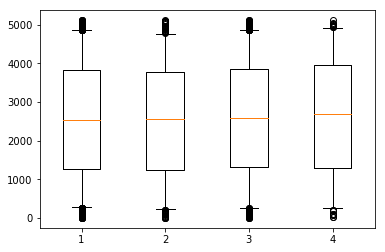

y


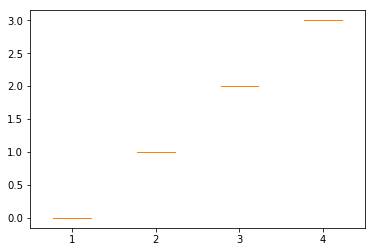

dur


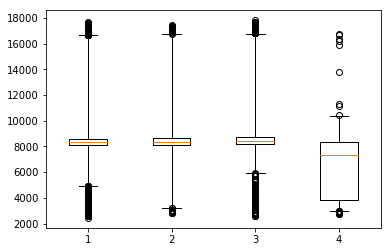

mean


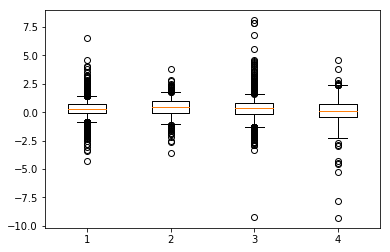

median


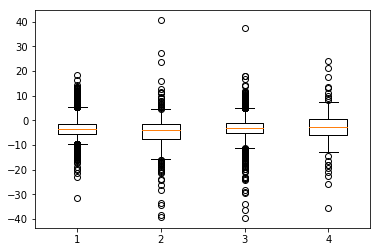

max


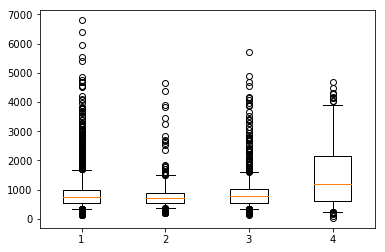

var


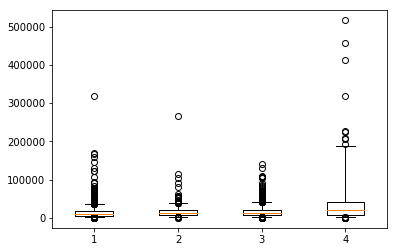

std_dev


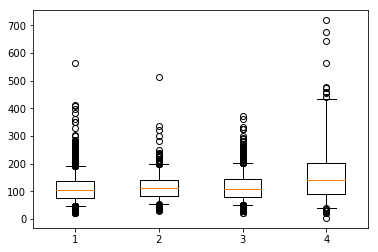

abs_dev


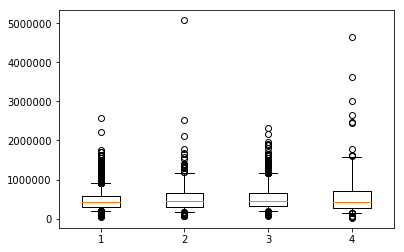

kurtosis


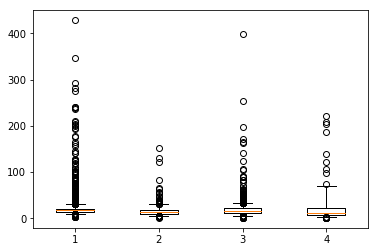

skewness


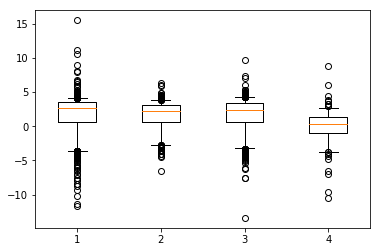

n_tempts


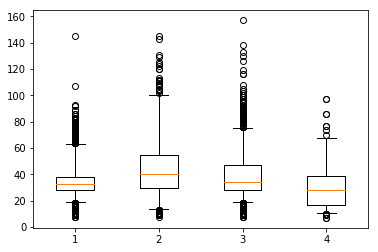

tempt_mean


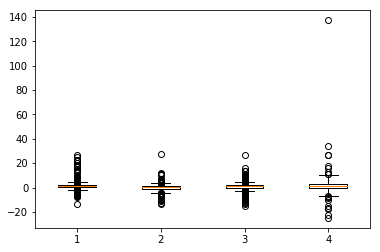

tempt_median


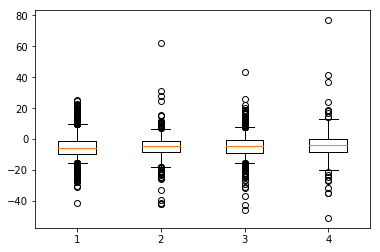

tempt_max


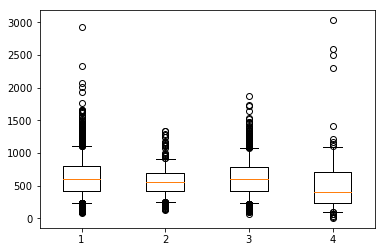

tempt_var


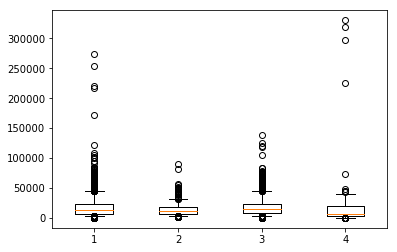

tempt_std_dev


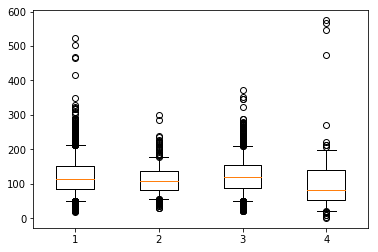

tempt_abs_dev


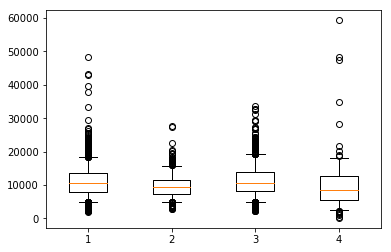

tempt_kurtosis


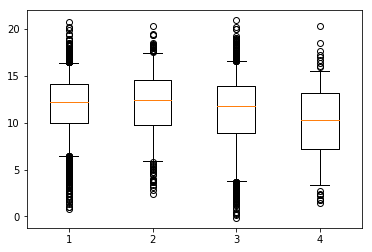

tempt_skewness


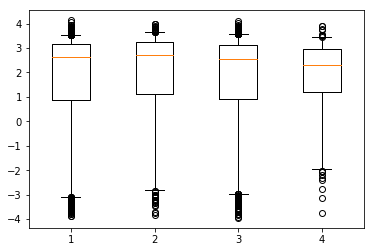

tempt_min


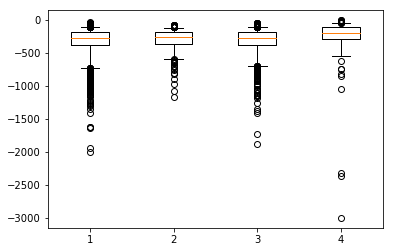

hr_min


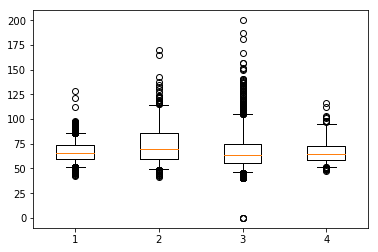

hr_mean


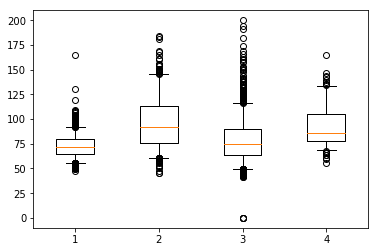

hr_median


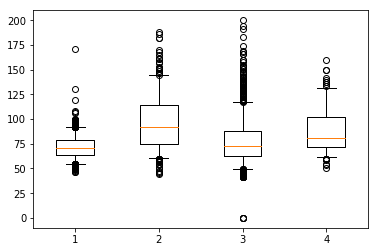

hr_max


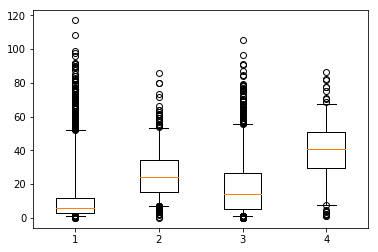

hr_var


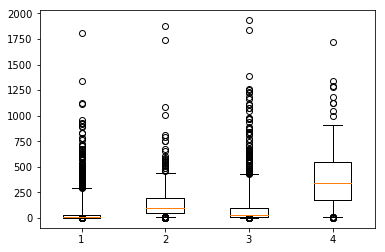

hr_std_dev


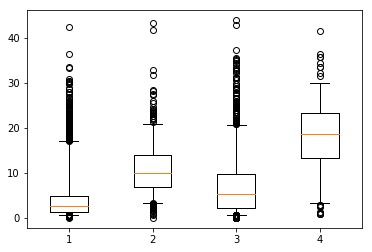

hr_abs_dev


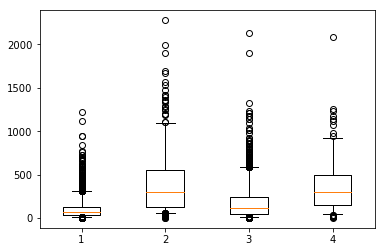

hr_kurtosis


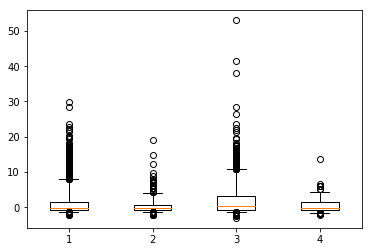

hr_skewness


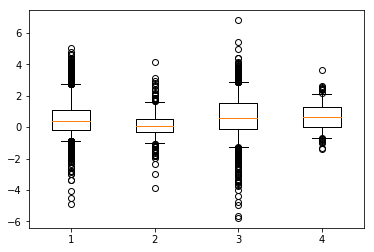

dhr_min


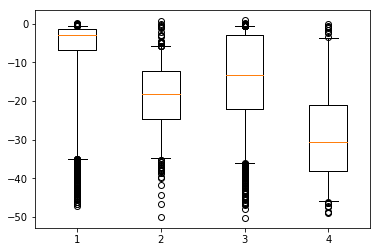

dhr_mean


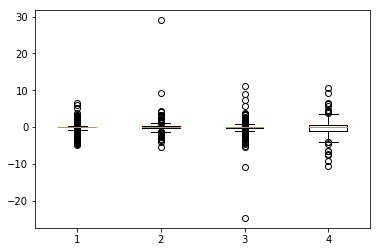

dhr_median


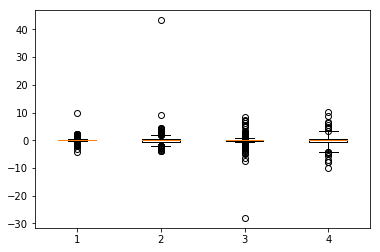

dhr_max


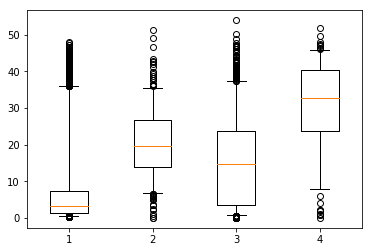

dhr_var


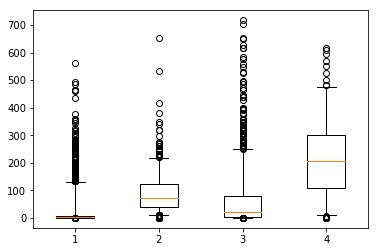

dhr_std_dev


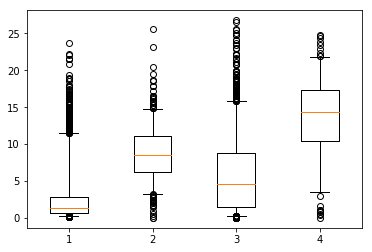

dhr_abs_dev


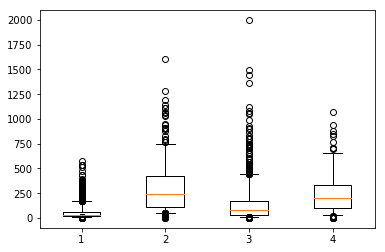

dhr_kurtosis


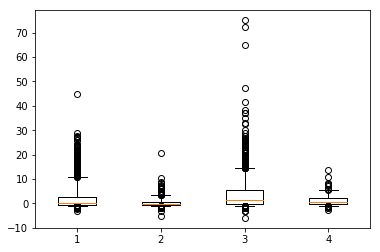

dhr_skewness


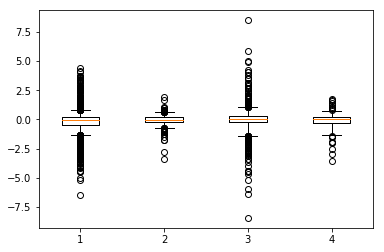

mean_interv


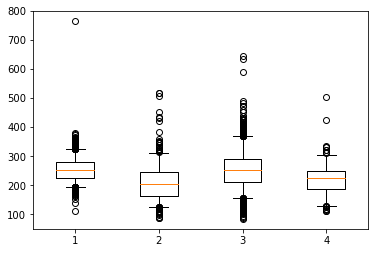

var_interv


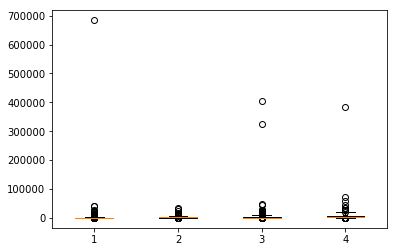

std_interv


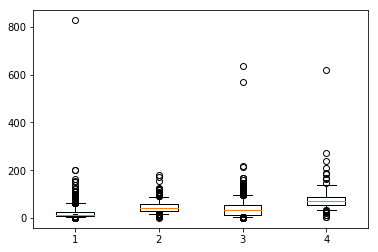

med_interv


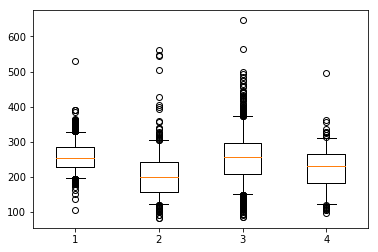

min_interv


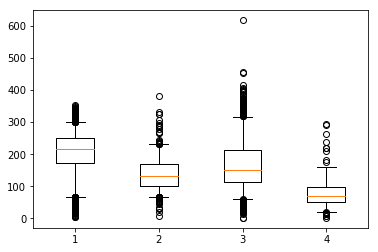

max_interv


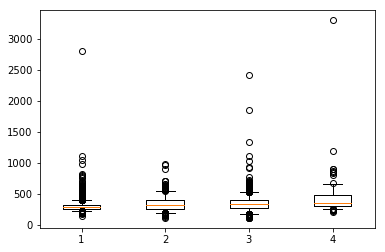

med_numex


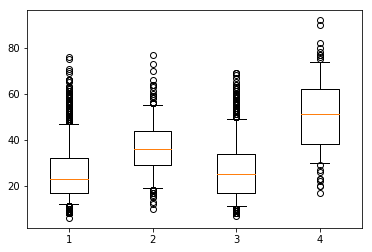

med_varex


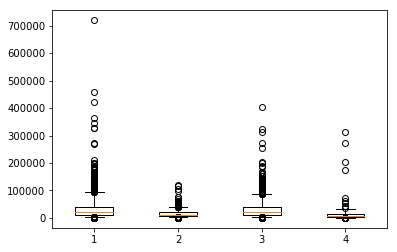

med_S


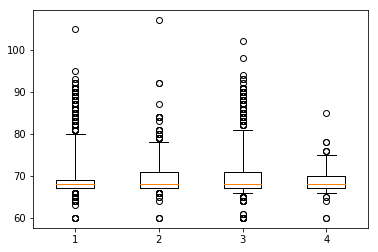

med_Q


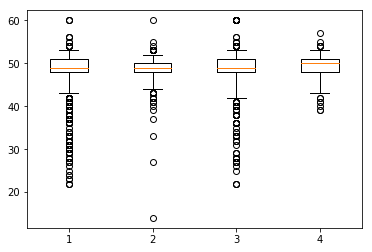

med_Sv


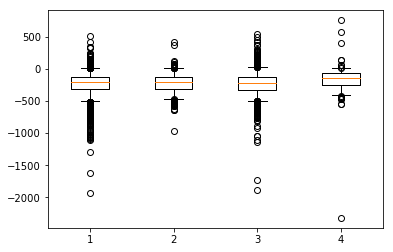

med_Rv


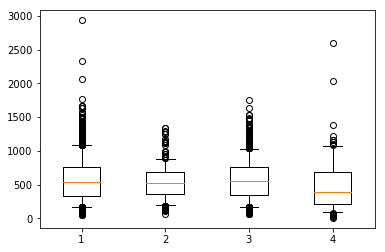

med_Qv


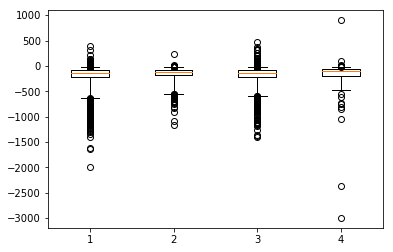

med_numz


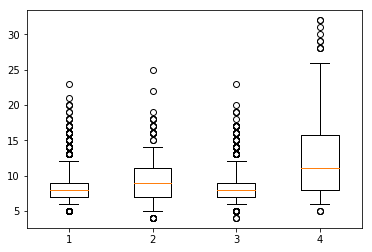

med_QZ


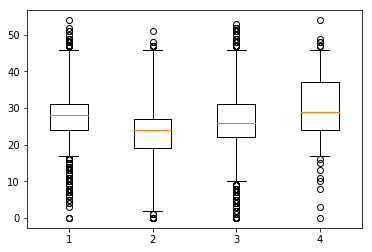

med_SZ


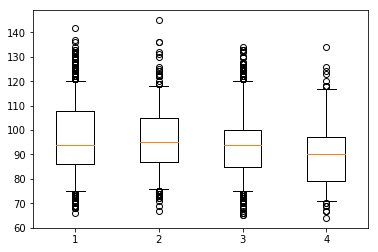

med_QS


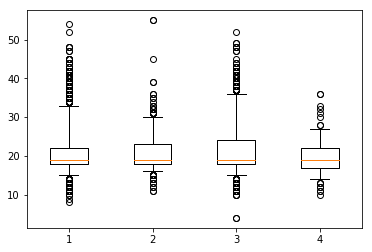

med_QZSZ


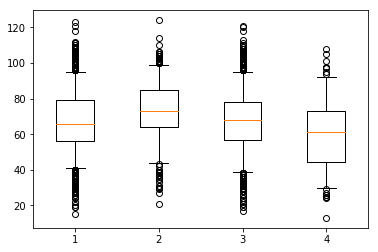

numex_var


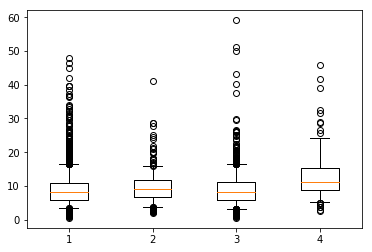

numex_med


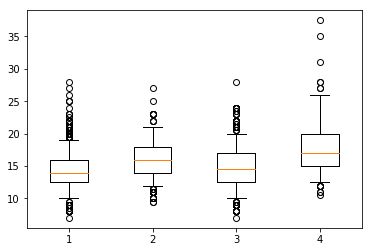

numex_iqr


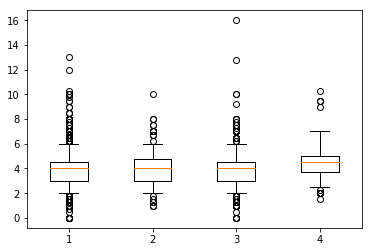

varex_var


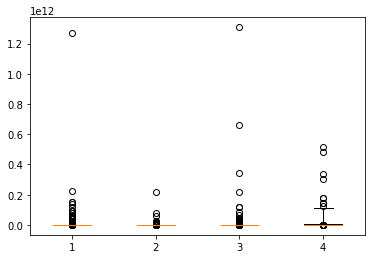

varex_med


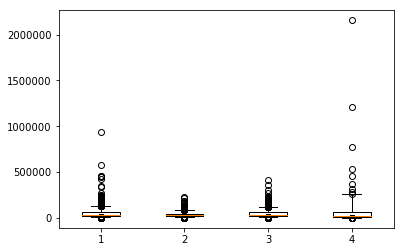

varex_iqr


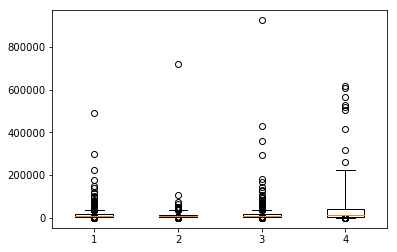

S_var


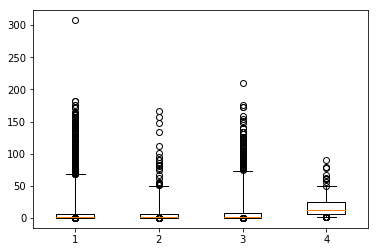

S_med


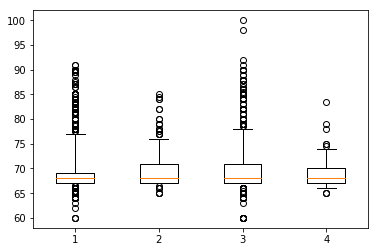

S_iqr


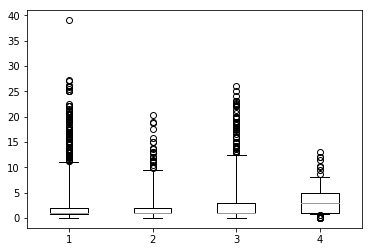

Q_var


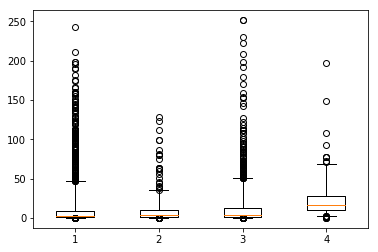

Q_med


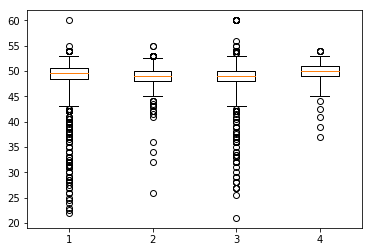

Q_iqr


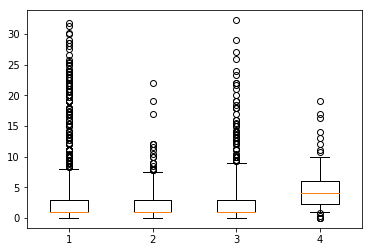

Sv_var


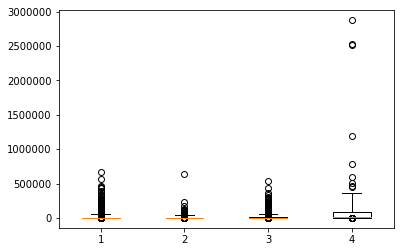

Sv_med


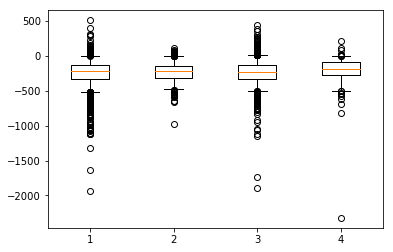

Sv_iqr


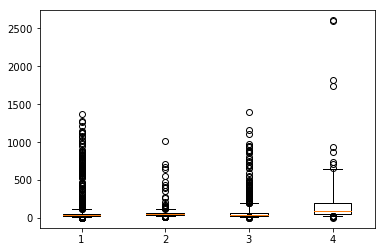

Rv_var


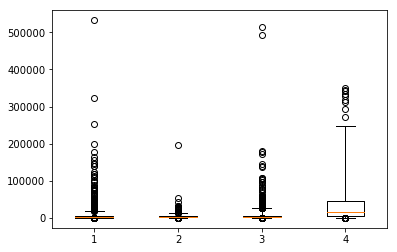

Rv_med


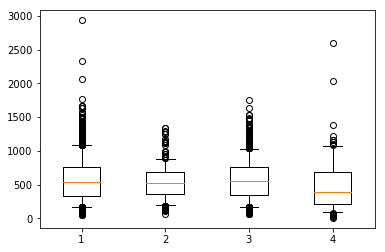

Rv_iqr


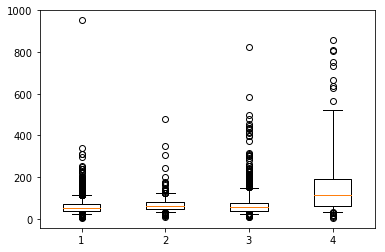

Qv_var


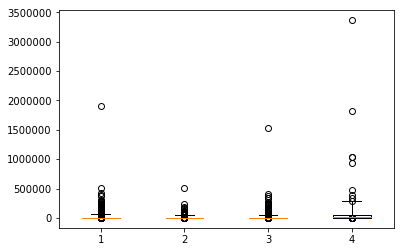

Qv_med


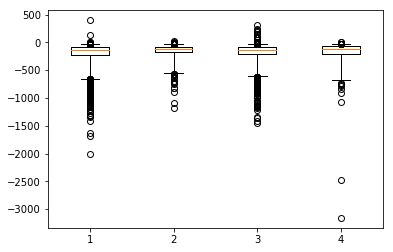

Qv_iqr


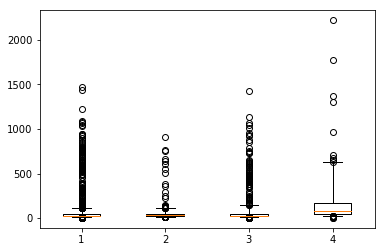

numz_var


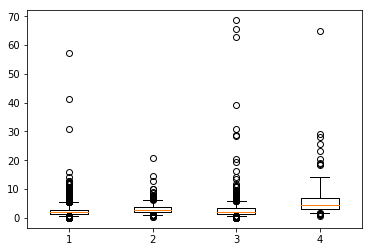

numz_med


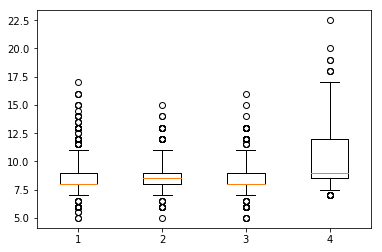

numz_iqr


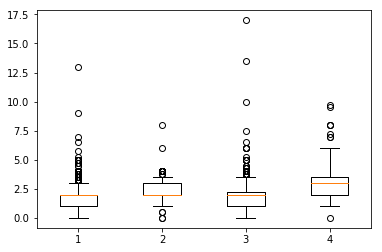

QZ_var


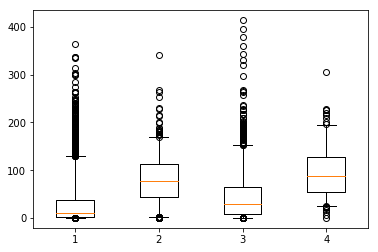

QZ_med


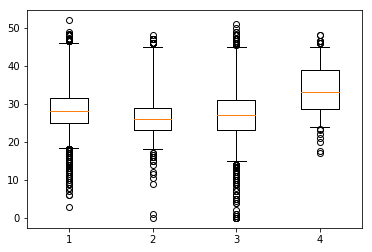

QZ_iqr


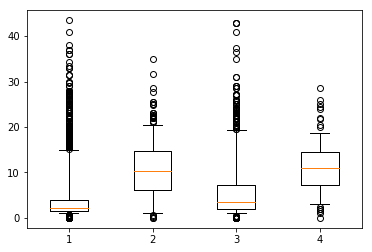

SZ_var


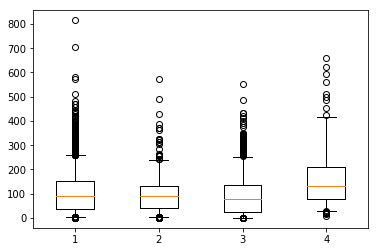

SZ_med


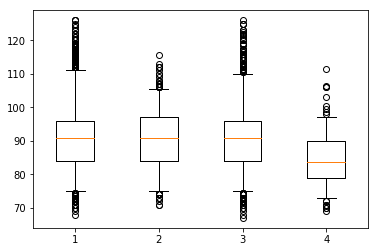

SZ_iqr


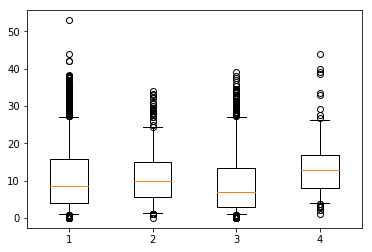

QS_var


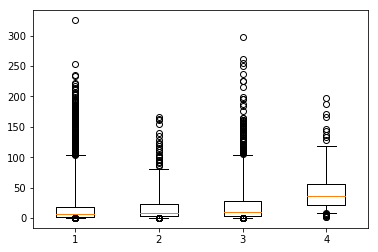

QS_med


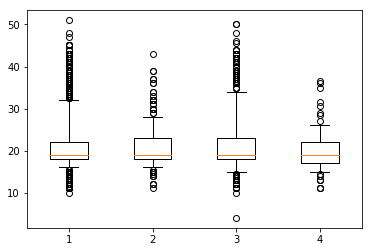

QS_iqr


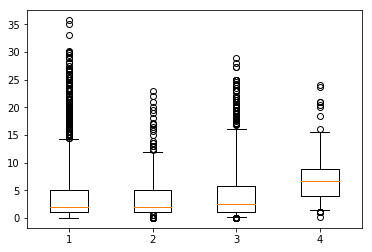

QZSZ_var


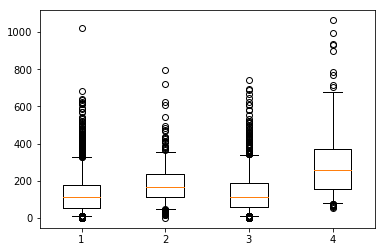

QZSZ_med


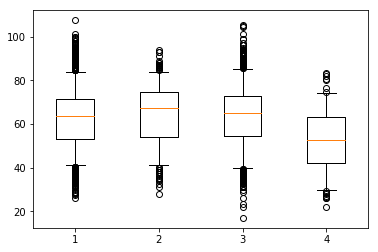

QZSZ_iqr


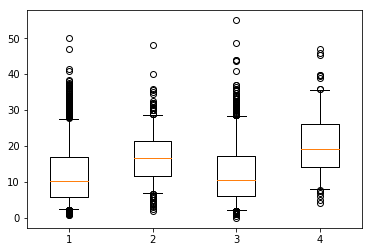

noise_avg


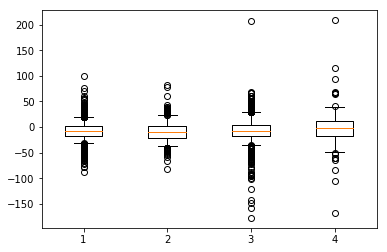

noise_rms


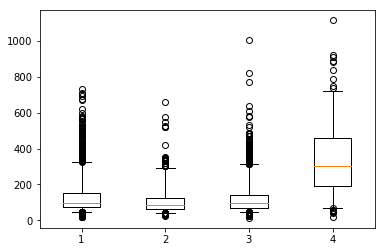

In [36]:
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat)
        box(feat)


# Pre Processing

In [39]:
myfeats = []
for feat in train.columns:
    if feat == 'id' or feat == 'y': continue
    if np.isscalar(train[feat][0]): myfeats.append(feat)

In [40]:
X_raw = train[myfeats].values
y_raw = train['y']

In [41]:
from sklearn.model_selection import train_test_split 

In [43]:
from sklearn.preprocessing import scale

In [44]:
X_raw = scale(X_raw)
X_tr, X_te, y_tr, y_te = train_test_split(X_raw, y_raw, test_size=0.25)

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [61]:
weights = {i:float(n_train)/counts[i] for i in range(4)}
print(counts)
print(weights)

[3030, 443, 1474, 170]
{0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.471506105834464, 3: 30.1}


# Try fitting:

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [120]:
tuned_parameters = [{'n_estimators': [500,1000], 
                     'max_depth': [None,800,2000], 
                     'criterion': ['gini'],
                     'min_samples_split': [2,], 
                     'min_samples_leaf': [5,], 
                     'min_weight_fraction_leaf': [0,], 
                     'max_features': [20],#['auto',17,20,30,60], 
                     'max_leaf_nodes': [None],#,100, 300, 500], 
                     'min_impurity_decrease': [0], 
                     'min_impurity_split': [1e-7,1e-6, 1e-8], 
                     'bootstrap': [True], 
                     'oob_score': [False,], 
                    },
                   ]
#scorer = make_scorer(f1_score, average = 'micro')

clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',
                                         ),
                   tuned_parameters, 
                   cv=5,
                   scoring='f1_micro',
                   n_jobs=-1, 
                   verbose=10,
                   )


clf.fit(X_tr, y_tr)


print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

pred_te  = clf.predict(X_te)
print('Plain predictions')
print('test  f1 =', f1_score(y_te, pred_te, average='micro'))
pred_tr = clf.predict(X_tr)
print('train f1 =', f1_score(y_tr, pred_tr, average='micro'))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te, sample_weight = samwe))
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:   59.4s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  47 out of  90 | elapsed:  1.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  90 | elapsed:  1.5min remaining:   50.6s
[Parallel(n_jobs=-1)]: Done  67 out of  90 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=-1)]: Done  77 out of  90 | elapsed:  1.9min remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  87 out of  90 | elapsed:  2.2min remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.2min finished
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-

/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/cluster/home/sgiles/.local/lib64/python3.6/site-


Grid scores on development set:

0.790 (+/-0.024) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_impurity_split': 1e-07, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 500, 'oob_score': False}
0.790 (+/-0.028) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_impurity_split': 1e-07, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 1000, 'oob_score': False}
0.789 (+/-0.034) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_impurity_split': 1e-06, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 500, 'oob_score': False}
0.790 (+/-0.033) for {'bootstrap': True, 'criterion': 'gini', 

In [102]:
param_names = clf.cv_results_['params'][0].keys()
param_mx = {pname: [str(params[pname]) for params in clf.cv_results_['params']] for pname in param_names}

<IPython.core.display.Javascript object>


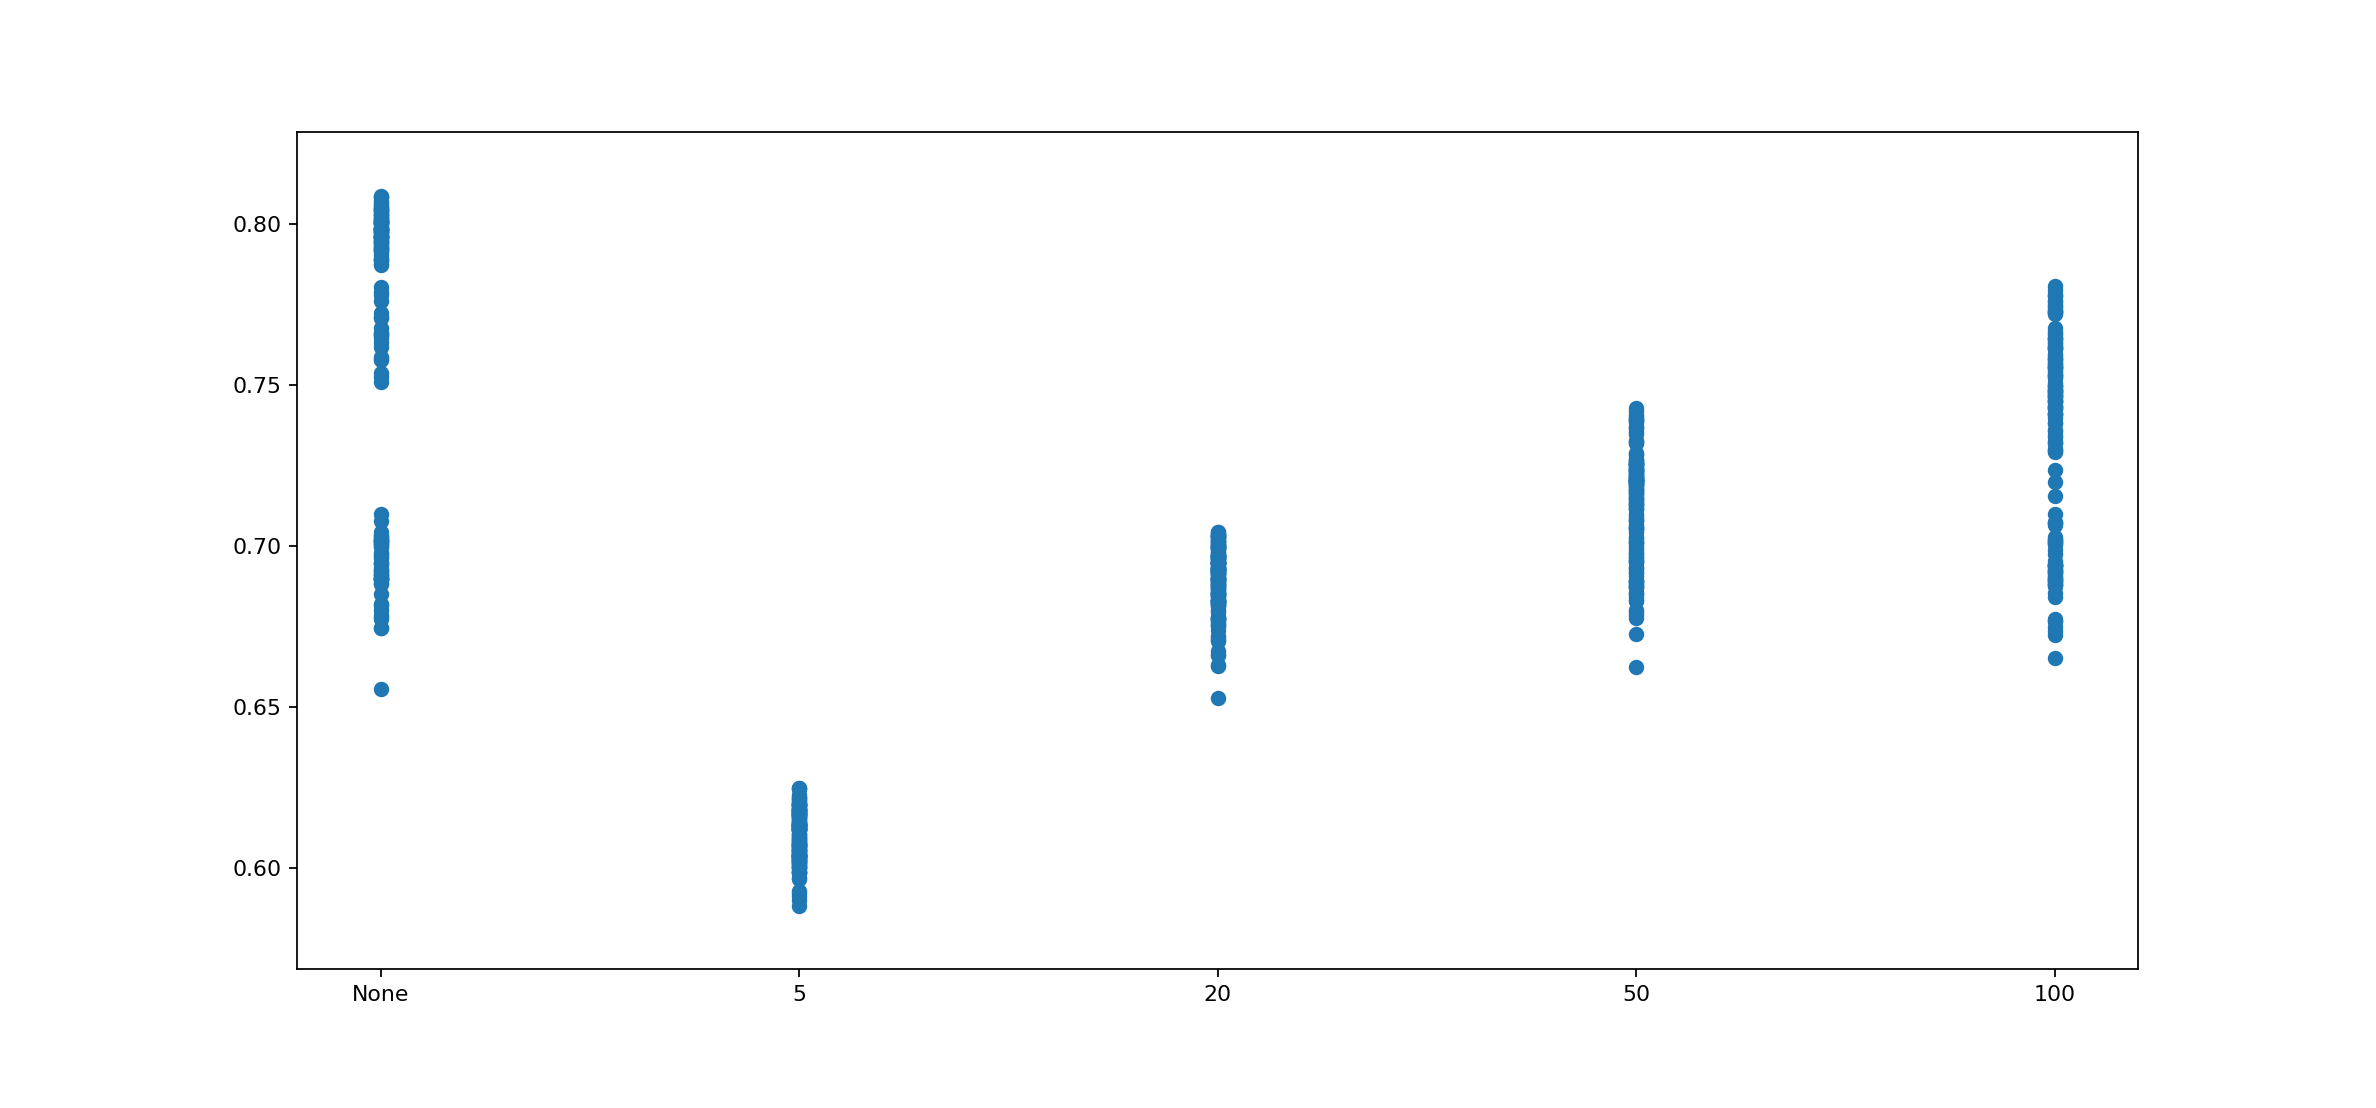

In [116]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 7)

plt.scatter(param_mx['max_leaf_nodes'], means)
plt.show()


# More feature ideas...

In [ ]:
raise # to stop automatic execution...

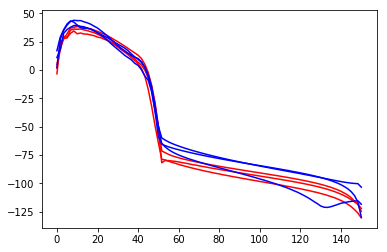

In [38]:
rows = subsets()[0].sample(3)#.iloc[0]
for id,row in rows.iterrows():
    #print(row.y)
    freqs, power = welch_spectrum(row.avg_tempt, sampling_rate=freq,size=180)
    plt.plot(freqs,power,c='red')
rows = subsets()[1].sample(3)#.iloc[0]
for id,row in rows.iterrows():
    #print(row.y)
    freqs, power = welch_spectrum(row.avg_tempt, sampling_rate=freq,size=180)
    plt.plot(freqs,power,c='blue')
plt.show()


In [ ]:
plt.boxplot([sub['hr_std_dev'] for sub in subsets])
plt.show()

In [ ]:
sample = train.loc[3778]
#sample = train1.sample(1).iloc[0]
ref = train0.loc[537]
#ref = train0.sample(1).iloc[0]

print(sample.id, ": ",sample.y)
print(ref.id, ": ",ref.y, '(ref)')

#plt.plot(sample.ts, sample.X)
plt.plot(sample.ts, sample.filtered, label=str(sample.y))
#plt.plot(templates_ts+sample.rpeaks[1]/freq, sample.templates[1])
#plt.show()

plt.plot(ref.ts, ref.filtered, label=str(ref.y))
#plt.plot(templates_ts+ref.rpeaks[1]/freq, ref.templates[1])

#plt.xlim([9,12])
plt.legend()
plt.show()

plt.plot(sample.heart_rate_ts-1, sample.heart_rate, label=str(sample.y))
plt.plot(   ref.heart_rate_ts*1.3333,    ref.heart_rate, label=str(   ref.y))
plt.plot( sample.heart_rate, label=str(sample.y))
plt.plot( ref.heart_rate, label=str(   ref.y))

plt.legend()
plt.show()



#plt.show()
for template in ref.templates:
    plt.plot(templates_ts, template,c='black')
#plt.plot(templates_ts, ref.avg_tempt, c='black')
for template in sample.templates:
    plt.plot(templates_ts, template)
plt.show()

In [ ]:
ids = [2312, 3606]
plt.boxplot(train.intervs.loc[ids])
plt.xticks(range(1+len(ids)), train.id.loc[ids])
plt.show()
plt.boxplot(train.heart_rate.loc[ids])
plt.show()

In [ ]:
train.loc[2312].var_interv

In [ ]:
train.loc[3606].var_interv

In [ ]:
subset = train
for id, sample in subset.sample(10).iterrows():
    print(id,':',sample.y)
    plt.plot(sample.intervs, label='filt')
    plt.ylim([50,500])
    #plt.plot(sample.ecg['ts'], sample.X, label='raw')
    #plt.plot(sample['templates_ts'], sample['templates'], label='template')
    plt.legend()
    plt.show()
    #plt.boxplot([sub['var_interv'] for sub in subsets])
plt.show()

In [ ]:
plt.boxplot([np.var(hrts) for sub in subsets for hrts in sub.heart_rate_ts])
plt.show()

In [ ]:
for subset in [train0, train1, train2, train3]:
    sample = subset.sample(1).iloc[0]
    print("id:",sample.id, '\tclass:', sample.y)
    plt.hist(sample.intervs,20, label=str(sample.y))
plt.legend()
plt.show()

In [ ]:
i=0
for subset in [train0, train1]:#, train2, train3]:
    plt.scatter(subset.y, subset.var_interv, label=i, s=1)
    plt.ylim([0,50000])
    i+=1
    plt.legend()
plt.show()

In [ ]:
[sample.var_interv for _, sample in train.loc[ids].iterrows()]

In [ ]:
ids =  []
for subset in [train0, train1, train2, train3]:
    for k in subset.sample(1).index.values:
        ids.append(k)
        sample = subset.loc[k]
        print("id:",k, 'class:', sample.y,'length:', len(sample.rpeaks))
        #for template in sample.ecg['templates'][5:-5]:
        #    plt.plot(template)
        #plt.show()
        plt.plot(sample.avg_tempt)
        plt.plot(sample.max_tempt)
        plt.plot(sample.min_tempt)
        plt.show()

#plt.legend()
#plt.show()

plt.boxplot(train.intervs[ids])
plt.show()

# CODE DUMPSTER:

In [ ]:
dhr = [np.diff(hr) for hr in train.heart_rate_ts]
plt.plot(dhr[0])

In [ ]:
#row = randrow(0)
#print(row.id,'y:',row.y)
#print('ntemps', row.n_tempts)
gfs=[get_g_feats(randrow(i).templates) for i in range(4)]
for feat in gfs[0]:
    print(feat)
    plt.boxplot([gf[feat] for gf in gfs])
    plt.show()

In [ ]:
row = randrow(-1)
#signal = row.avg_tempt[:3000]
signal = row.avg_tempt[:3000]
print(row.id,'y:',row.y)
extrema, values = find_extrema(signal)
plt.plot(extrema, values)
plt.plot(signal)
#R_peaks, S_point, Q_point = EKG_QRS_detect(signal, freq, True, True)
#print(S_point-Q_point)
R = np.array([60]) # R is always at sample 60 within the template
S = find_S_point(signal, R)[0]
Q = find_Q_point(signal, R)[0]
R=R[0]
S_val = signal[S]
R_val = signal[R]
Q_val = signal[Q]
plt.scatter([Q,R,S],[Q_val,R_val,S_val])
print(S-Q)
print(len(extrema))
zeros = zero_cross(signal)['zeros']
QZ = np.max(zeros[zeros<Q])
SZ = np.min(zeros[zeros>S])
plt.axvline(x=QZ)
plt.axvline(x=SZ)

In [ ]:

row = randrow(0)
print(row.id,'y:',row.y)
print('ntemps', len(row.templates))
for signal in row.templates:
    extrema, values = find_extrema(signal)
    numex = len(extrema)
    varex = np.var(values)
    R = np.array([60]) # R is always at sample 60 within the template
    S = find_S_point(signal, R)[0]
    Q = find_Q_point(signal, R)[0]
    R=R[0]
    Sv = signal[S]
    Rv = signal[R]
    Qv = signal[Q]
    QS = S-Q
    zeros = zero_cross(signal)['zeros']
    numz = len(zeros)
    QZ = np.max(np.append(zeros[zeros<Q],0))
    SZ = np.min(np.append(zeros[zeros>S],179))
    QZSZ = SZ-QZ
    numexs.append(numex)
    varexs.append(varex)
    Ss.append(S)
    Qs.append(Q)
    Rs.append(R)
    Svs.append(Sv)
    Rvs.append(Rv)
    Qvs.append(Qv)
    numzs.append(numz)
    QZs.append(QZ)
    SZs.append(SZ)
    QSs.append(QS)
    QZSZs.append(QZSZ)
    
numexsTMP = [np.array(numexs)]
varexsTMP = [np.array(varexs)]
SsTMP = [np.array(Ss)]
QsTMP = [np.array(Qs)]
RsTMP = [np.array(Rs)]
SvsTMP = [np.array(Svs)]
RvsTMP = [np.array(Rvs)]
QvsTMP = [np.array(Qvs)]
numzsTMP = [np.array(numzs)]
QZsTMP = [np.array(QZs)]
SZsTMP = [np.array(SZs)]
QSsTMP = [np.array(QSs)]
QZSZsTMP = [np.array(QZSZs)]
    
row = randrow(1)
print(row.id,'y:',row.y)
print('ntemps', len(row.templates))
for signal in row.templates:
    extrema, values = find_extrema(signal)
    numex = len(extrema)
    varex = np.var(values)
    R = np.array([60]) # R is always at sample 60 within the template
    S = find_S_point(signal, R)[0]
    Q = find_Q_point(signal, R)[0]
    R=R[0]
    Sv = signal[S]
    Rv = signal[R]
    Qv = signal[Q]
    QS = S-Q
    zeros = zero_cross(signal)['zeros']
    numz = len(zeros)
    QZ = np.max(np.append(zeros[zeros<Q],0))
    SZ = np.min(np.append(zeros[zeros>S],179))
    QZSZ = SZ-QZ
    numexs.append(numex)
    varexs.append(varex)
    Ss.append(S)
    Qs.append(Q)
    Rs.append(R)
    Svs.append(Sv)
    Rvs.append(Rv)
    Qvs.append(Qv)
    numzs.append(numz)
    QZs.append(QZ)
    SZs.append(SZ)
    QSs.append(QS)
    QZSZs.append(QZSZ)
    
numexsTMP.append(np.array(numexs))
varexsTMP.append(np.array(varexs))
SsTMP.append(np.array(Ss))
QsTMP.append(np.array(Qs))
RsTMP.append(np.array(Rs))
SvsTMP.append(np.array(Svs))
RvsTMP.append(np.array(Rvs))
QvsTMP.append(np.array(Qvs))
numzsTMP.append(np.array(numzs))
QZsTMP.append(np.array(QZs))
SZsTMP.append(np.array(SZs))
QSsTMP.append(np.array(QSs))
QZSZsTMP.append(np.array(QZSZs))

row = randrow(2)
print(row.id,'y:',row.y)
print('ntemps', len(row.templates))
for signal in row.templates:
    extrema, values = find_extrema(signal)
    numex = len(extrema)
    varex = np.var(values)
    R = np.array([60]) # R is always at sample 60 within the template
    S = find_S_point(signal, R)[0]
    Q = find_Q_point(signal, R)[0]
    R=R[0]
    Sv = signal[S]
    Rv = signal[R]
    Qv = signal[Q]
    QS = S-Q
    zeros = zero_cross(signal)['zeros']
    numz = len(zeros)
    QZ = np.max(np.append(zeros[zeros<Q],0))
    SZ = np.min(np.append(zeros[zeros>S],179))
    QZSZ = SZ-QZ
    numexs.append(numex)
    varexs.append(varex)
    Ss.append(S)
    Qs.append(Q)
    Rs.append(R)
    Svs.append(Sv)
    Rvs.append(Rv)
    Qvs.append(Qv)
    numzs.append(numz)
    QZs.append(QZ)
    SZs.append(SZ)
    QSs.append(QS)
    QZSZs.append(QZSZ)
    
numexsTMP.append(np.array(numexs))
varexsTMP.append(np.array(varexs))
SsTMP.append(np.array(Ss))
QsTMP.append(np.array(Qs))
RsTMP.append(np.array(Rs))
SvsTMP.append(np.array(Svs))
RvsTMP.append(np.array(Rvs))
QvsTMP.append(np.array(Qvs))
numzsTMP.append(np.array(numzs))
QZsTMP.append(np.array(QZs))
SZsTMP.append(np.array(SZs))
QSsTMP.append(np.array(QSs))
QZSZsTMP.append(np.array(QZSZs))

row = randrow(3)
print(row.id,'y:',row.y)
print('ntemps', len(row.templates))
for signal in row.templates:
    extrema, values = find_extrema(signal)
    numex = len(extrema)
    varex = np.var(values)
    R = np.array([60]) # R is always at sample 60 within the template
    S = find_S_point(signal, R)[0]
    Q = find_Q_point(signal, R)[0]
    R=R[0]
    Sv = signal[S]
    Rv = signal[R]
    Qv = signal[Q]
    QS = S-Q
    zeros = zero_cross(signal)['zeros']
    numz = len(zeros)
    QZ = np.max(np.append(zeros[zeros<=Q],0))
    SZ = np.min(np.append(zeros[zeros>=S],179))
    QZSZ = SZ-QZ
    numexs.append(numex)
    varexs.append(varex)
    Ss.append(S)
    Qs.append(Q)
    Rs.append(R)
    Svs.append(Sv)
    Rvs.append(Rv)
    Qvs.append(Qv)
    numzs.append(numz)
    QZs.append(QZ)
    SZs.append(SZ)
    QSs.append(QS)
    QZSZs.append(QZSZ)
    
numexsTMP.append(np.array(numexs))
varexsTMP.append(np.array(varexs))
SsTMP.append(np.array(Ss))
QsTMP.append(np.array(Qs))
RsTMP.append(np.array(Rs))
SvsTMP.append(np.array(Svs))
RvsTMP.append(np.array(Rvs))
QvsTMP.append(np.array(Qvs))
numzsTMP.append(np.array(numzs))
QZsTMP.append(np.array(QZs))
SZsTMP.append(np.array(SZs))
QSsTMP.append(np.array(QSs))
QZSZsTMP.append(np.array(QZSZs))

numexs = numexsTMP
varexs = varexsTMP
Ss = SsTMP
Qs = QsTMP
Rs = RsTMP
Svs = SvsTMP
Rvs = RvsTMP
Qvs = QvsTMP
numzs = numzsTMP
QZs = QZsTMP
SZs = SZsTMP
QSs = QSsTMP
QZSZs = QZSZsTMP

print('numexs')
#mednumexs = np.median(numexs)
#varnumexs = np.var(numexs)
plt.boxplot(numexs)
plt.show()
print('varexs')
#medvarexs = np.median(varexs)
#varvarexs = np.var(varexs)
plt.boxplot(varexs)
plt.show()
print('Ss')
#medSs = np.median(Ss)
#varSs = np.var(Ss)
plt.boxplot(Ss)
plt.show()
print('Qs')
#medQs = np.median(Qs)
#varQs = np.var(Qs)
plt.boxplot(Qs)
plt.show()
print('Rs')
#medRs = np.median(Rs)
#varRs = np.var(Rs)
plt.boxplot(Rs)
plt.show()
print('Svs')
#medSvs = np.median(Svs)
#varSvs = np.var(Svs)
plt.boxplot(Svs)
plt.show()
print('Rvs')
#medRvs = np.median(Rvs)
#varRvs = np.var(Rvs)
plt.boxplot(Rvs)
plt.show()
print('Qvs')
#medQvs = np.median(Qvs)
#varQvs = np.var(Qvs)
plt.boxplot(Qvs)
plt.show()
print('numzs')
#mednumzs = np.median(numzs)
#varnumzs = np.var(numzs)
plt.boxplot(numzs)
plt.show()
print('QZs')
#medQZs = np.median(QZs)
#varQZs = np.var(QZs)
plt.boxplot(QZs)
plt.show()
print('SZs')
#medSZs = np.median(SZs)
#varSZs = np.var(SZs)
plt.boxplot(SZs)
plt.show()
print('QSs')
#medQSs = np.median(QSs)
#varQSs = np.var(QSs)
plt.boxplot(QSs)
plt.show()
print('QZSZs')
#medQZSZs = np.median(QZSZs)
#varQZSZs = np.var(QZSZs)
plt.boxplot(QZSZs)
plt.show()